# Cell Capsule Analysis
This notebook analyses cells and their capsules to provide metrics on areas of different regions.
Images must be marked with a green ellipse to denote the cell wall.

Steps:
1) User select the image to be processed
2) Detect the cell outline and generate a cell mask
3) User define a cell capsule ROI
4) Detect the cell capsule outline and generate a cell capsule mask
5) User select white space in the image to set threshold
6) Detect white space and generate a white space mask
7) User enter scale bar size in nm
8) User enter scale bar ROI
9) Generate the output report

## Import required modules

In [225]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets
from ipywidgets import Layout
from tkinter import Tk
from tkinter.filedialog import askopenfilename

## STEP 1: Select image file to analyse

In [226]:
# create a file dialog to select the image
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing

# open the file dialog with default path to the image folder
image_path = askopenfilename(initialdir = "images/",title = "Select image",filetypes = (("tif files","*.tif"),("all files","*.*")))

2023-09-30 23:43:35.897 python[37868:6289139] +[CATransaction synchronize] called within transaction
2023-09-30 23:43:35.933 python[37868:6289139] +[CATransaction synchronize] called within transaction
2023-09-30 23:43:36.054 python[37868:6289139] +[CATransaction synchronize] called within transaction
2023-09-30 23:43:37.977 python[37868:6289139] +[CATransaction synchronize] called within transaction
2023-09-30 23:43:42.451 python[37868:6289139] Bad cursor rect event, flags = 0


## STEP 2: Detect the cell outline and generate a cell mask

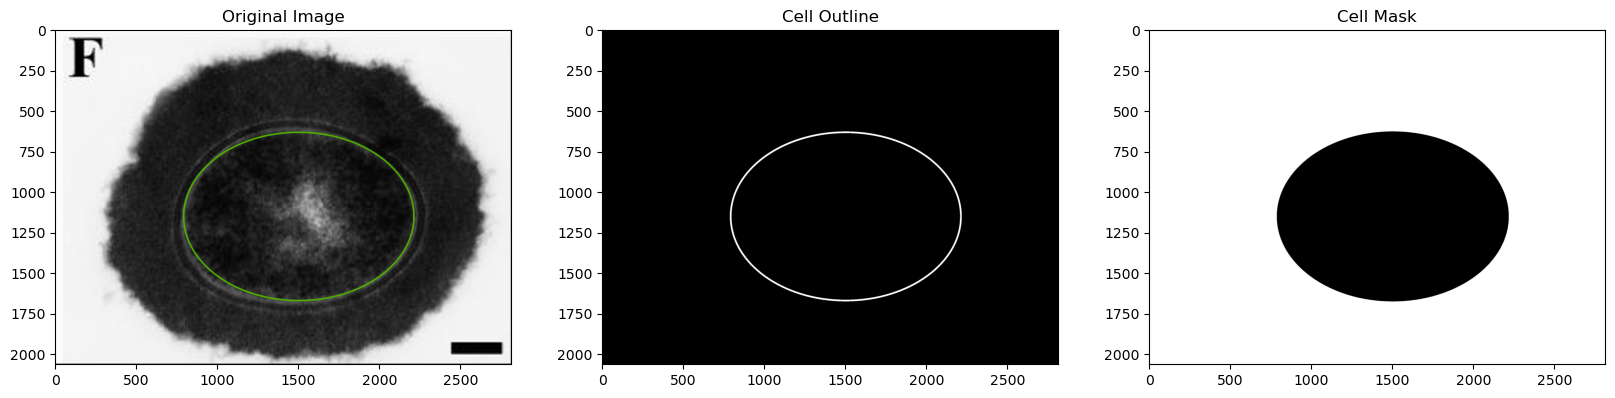

In [227]:
# Read the image
image = cv2.imread(image_path)

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

imageOriginal = image.copy()

# Define range for green color in HSV
lower_green = (35, 50, 50)
upper_green = (85, 255, 255)

# Threshold the image to get only green
green_mask = cv2.inRange(hsv, lower_green, upper_green)

# Find contours
contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming the largest contour is our green outline, sort contours by area
contour = max(contours, key=cv2.contourArea)

cell_mask = imageOriginal.copy()

# fill the contour with green
cv2.drawContours(cell_mask, [contour], 0, (0, 255, 0), -1)

# create a mask for the cell
lower_green = (0, 255, 0)
upper_green = (0, 255, 0)
cell_mask = cv2.inRange(cell_mask, lower_green, upper_green)
cell_mask = cv2.bitwise_not(cell_mask)

# create a plot with three figures, one for the original image, one for the cell outline and one for the cell mask
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(imageOriginal)

plt.subplot(1,3,2)
plt.title('Cell Outline')
plt.imshow(green_mask, cmap='gray')

plt.subplot(1,3,3)
plt.title('Cell Mask')
plt.imshow(cell_mask, cmap='gray')

plt.show()

## STEP 3: Define the cell capsule ROI (Region of Interest)

In [228]:
# create an iteractive plot to adjust the diameter of the cell
# add a button to save the value
from IPython.display import display, Javascript

roi = cv2.bitwise_not(green_mask)  # copy the contour of the cell wall, and invert
global imageROI
global config_ROI_pixels

# define the callback function
def updateROI(pixels):
    global imageROI
    global config_ROI_pixels
    config_ROI_pixels = pixels

    roi = cv2.bitwise_not(green_mask)  # copy the contour of the cell wall, and invert

    dist = cv2.distanceTransform(roi, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    ring = cv2.inRange(dist, pixels-0.5, pixels+0.5) # take all pixels at distance set by slider +/- 0.5
    contours, _ = cv2.findContours(ring, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    vis = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)

    # overlay the ROI on the original image
    imageROI = imageOriginal.copy()
    cv2.drawContours(imageROI, contours, 0, (255,0,0),2)

    plt.imshow(imageROI)

# callback function for the save button
def saveROI(btn):
    print("Saved ROI - move to next cell")
    global imageROI
    global userDefinedROI 
    userDefinedROI = imageROI


widgets.interact(updateROI, pixels=widgets.IntSlider(value=1,min=1,max=500,step=1,description="No. Pixels :",layout=Layout(width='1000px')))
button = widgets.Button(description='Save', disabled=False, button_style='success', tooltip='Click me', icon='check')
button.on_click(saveROI)
display(button)

interactive(children=(IntSlider(value=1, description='No. Pixels :', layout=Layout(width='1000px'), max=500, m…

Button(button_style='success', description='Save', icon='check', style=ButtonStyle(), tooltip='Click me')

Saved ROI - move to next cell


## STEP 4: Detect the cell capsule outline and generate a cell capsule mask

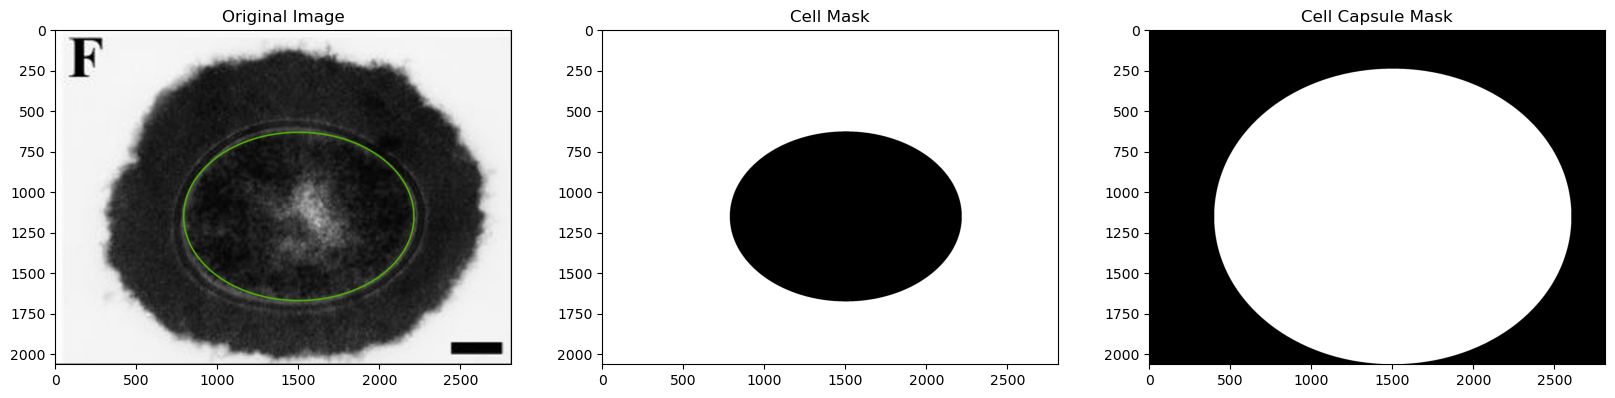

In [229]:
global userDefinedROI

# get the name of the input image
imageName = image_path.split('/')[-1].split('.')[0]

#  create a path to the output image
outputImagePath = 'outputimages/' + imageName + '_output'

# check if the outputimages folder exists
if not os.path.exists('outputimages'):
    #  if it doesn't exist, create it
    os.makedirs('outputimages')

def get_next_filename(base_filename, extension):
    index = 1
    new_filename = f"{base_filename}.{extension}"
    
    while os.path.exists(new_filename):
        new_filename = f"{base_filename}_{index}.{extension}"
        index += 1
        
    return new_filename

next_filename = get_next_filename(outputImagePath, "tif")

#  save the image
cv2.imwrite(next_filename, userDefinedROI)

# create a mask from the red outline
lower_red = (255, 0, 0)
upper_red = (255, 0, 0)
red_mask = cv2.inRange(userDefinedROI, lower_red, upper_red)

# create a contour from the red outline
contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming the largest contour is our red outline, sort contours by area
contour = max(contours, key=cv2.contourArea)

# create a copy of the original image
cell_capsule_mask = imageOriginal.copy()

# fill the contour with red
cv2.drawContours(cell_capsule_mask, [contour], 0, (255, 0, 0), -1)

# create a mask for the cell capsule
cell_capsule_mask = cv2.inRange(cell_capsule_mask, lower_red, upper_red)

# create a plot with three figures, one for the original image, one for the cell outline and one for the cell mask
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(imageOriginal)

plt.subplot(1,3,2)
plt.title('Cell Mask')
plt.imshow(cell_mask, cmap='gray')

plt.subplot(1,3,3)
plt.title('Cell Capsule Mask')
plt.imshow(cell_capsule_mask, cmap='gray')


## STEP 5: Select whitespace within the image to set threshold levels

In [230]:
global blankSpace

image = userDefinedROI.copy()

def plot_region(x=0, y=0, width=100, height=100):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image)
    rect = plt.Rectangle((x, y), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

def save_selected_region(btn):
    global blankSpace
    global config_Whitespace_x_slider
    global config_Whitespace_y_slider
    global config_Whitespace_width_slider
    global config_Whitespace_height_slider

    blankSpace = image[y_slider.value:y_slider.value+height_slider.value, x_slider.value:x_slider.value+width_slider.value]

    config_Whitespace_x_slider = x_slider.value
    config_Whitespace_y_slider = y_slider.value
    config_Whitespace_width_slider = width_slider.value
    config_Whitespace_height_slider = height_slider.value

# Create sliders for adjusting the region
x_slider = widgets.IntSlider(min=0, max=image.shape[1]-10, step=1, value=0, description='X:')
y_slider = widgets.IntSlider(min=0, max=image.shape[0]-10, step=1, value=0, description='Y:')
width_slider = widgets.IntSlider(min=10, max=image.shape[1], step=1, value=100, description='Width:')
height_slider = widgets.IntSlider(min=10, max=image.shape[0], step=1, value=100, description='Height:')

# Create a button for saving the selected region
save_button = widgets.Button(description='Save', disabled=False, button_style='success', tooltip='Click me', icon='check')
save_button.on_click(save_selected_region)

ui = widgets.VBox([x_slider, y_slider, width_slider, height_slider, save_button])
out = widgets.interactive_output(plot_region, {'x': x_slider, 'y': y_slider, 'width': width_slider, 'height': height_slider})

display(ui, out)




Output()

## STEP 6: Detect whitespace and generate a whitespace mask

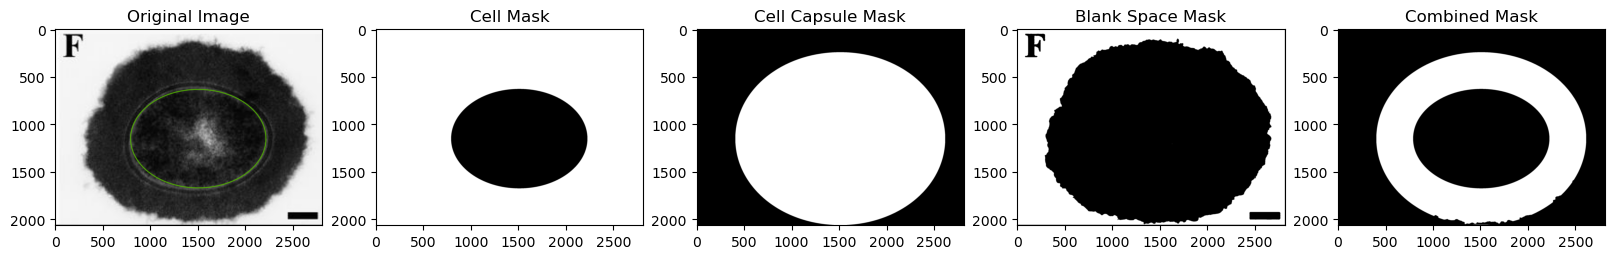

In [231]:
# using the selected blank space, calculate the average intensity of the pixels

# convert the image to grayscale
blankSpaceGray = cv2.cvtColor(blankSpace, cv2.COLOR_BGR2GRAY)

# calculate the average intensity of the pixels
averageIntensity = np.mean(blankSpaceGray)

# convert the original image to grayscale
imageOriginalGray = cv2.cvtColor(imageOriginal, cv2.COLOR_BGR2GRAY)

# create a mask of the blank space using the original image
blankSpaceMask = cv2.inRange(imageOriginalGray, (averageIntensity-50), (averageIntensity+50))

# create a plot with five images, the original image, the cell mask, the cell capsule mask, the blank space mask and the combined mask
plt.figure(figsize=(20,10))
plt.subplot(1,5,1)
plt.title('Original Image')
plt.imshow(imageOriginal)

plt.subplot(1,5,2)
plt.title('Cell Mask')
plt.imshow(cell_mask, cmap='gray')

plt.subplot(1,5,3)
plt.title('Cell Capsule Mask')
plt.imshow(cell_capsule_mask, cmap='gray')

plt.subplot(1,5,4)
plt.title('Blank Space Mask')
plt.imshow(blankSpaceMask, cmap='gray')

plt.subplot(1,5,5)
plt.title('Combined Mask')
combinedMask = cv2.bitwise_and(cell_mask, cell_capsule_mask)
invt_blankSpaceMask = cv2.bitwise_not(blankSpaceMask)
combinedMask = cv2.bitwise_and(combinedMask, invt_blankSpaceMask)
plt.imshow(combinedMask, cmap='gray')


## STEP 7: Select the scale bar size in nm

In [232]:
# create a widget for entering the scale bar width in Nanometres
# Adjusting the style of the widget

numInput = widgets.IntText(value=600, 
       description='Scale bar width (nm):', 
       style={'description_width': 'initial'},
       layout = widgets.Layout(width='500px')
)

# function to save the scale bar width
def saveScaleBarWidth(b):
    global scaleBarWidthNanometres
    scaleBarWidthNanometres = numInput.value
    print('Scale bar width set to: ' + str(scaleBarWidthNanometres) + ' Nanometres')

# create a button to save the value
button = widgets.Button(description='Enter', disabled=False, button_style='success', tooltip='Click me', icon='check')
button.on_click(saveScaleBarWidth)
display(numInput)

display(button)

IntText(value=600, description='Scale bar width (nm):', layout=Layout(width='500px'), style=DescriptionStyle(d…

Button(button_style='success', description='Enter', icon='check', style=ButtonStyle(), tooltip='Click me')

Scale bar width set to: 600 Nanometres


## STEP 8: Select the scale bar ROI

In [233]:
# create a interactive plot for the user to select the scale bar
# add a button to save the value

global scaleBar

image = imageOriginal.copy()

def plot_region(x=0, y=0, width=100, height=100):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image)
    rect = plt.Rectangle((x, y), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

def save_selected_region(btn):
    global scaleBar

    global config_ScaleBar_x_slider
    global config_ScaleBar_y_slider
    global config_ScaleBar_width_slider
    global config_ScaleBar_height_slider

    scaleBar = image[y_slider.value:y_slider.value+height_slider.value, x_slider.value:x_slider.value+width_slider.value]

    config_ScaleBar_x_slider = x_slider.value
    config_ScaleBar_y_slider = y_slider.value
    config_ScaleBar_width_slider = width_slider.value
    config_ScaleBar_height_slider = height_slider.value

# Create sliders for adjusting the region
x_slider = widgets.IntSlider(min=0, max=image.shape[1]-10, step=1, value=1320, description='X:')
y_slider = widgets.IntSlider(min=0, max=image.shape[0]-10, step=1, value=2250, description='Y:')
width_slider = widgets.IntSlider(min=10, max=image.shape[1], step=1, value=554, description='Width:')
height_slider = widgets.IntSlider(min=10, max=image.shape[0], step=1, value=40, description='Height:')

# Create a button for saving the selected region
save_button = widgets.Button(description='Save', disabled=False, button_style='success', tooltip='Click me', icon='check')
save_button.on_click(save_selected_region)

ui = widgets.VBox([x_slider, y_slider, width_slider, height_slider, save_button])
out = widgets.interactive_output(plot_region, {'x': x_slider, 'y': y_slider, 'width': width_slider, 'height': height_slider})

display(ui, out)

Output()

## STEP 9: Perform calculations and generate the output report

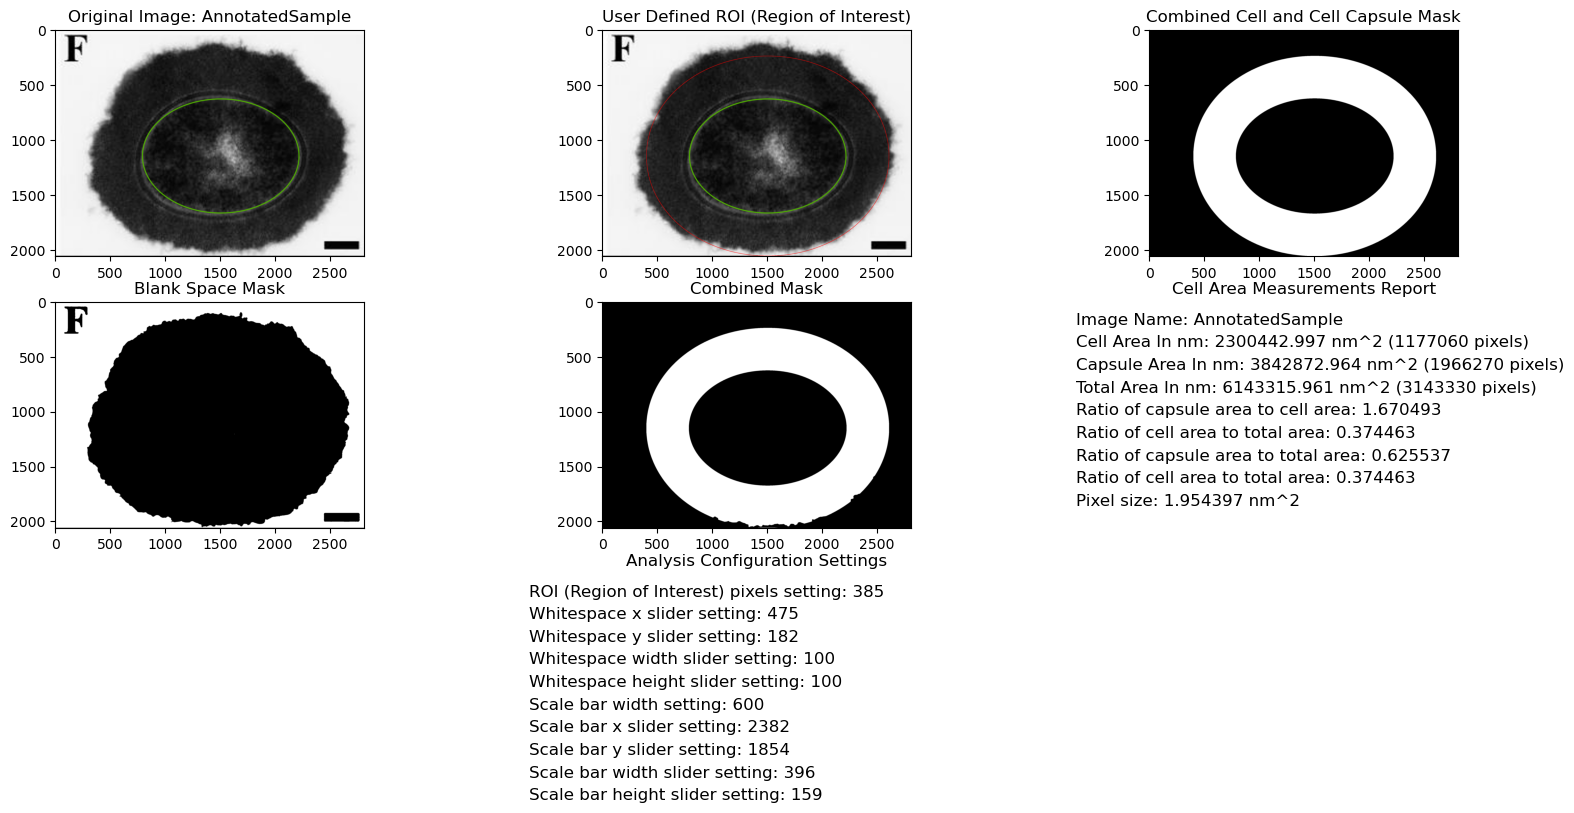

In [236]:
# RUN CALULATIONS FOR THE SCALE BAR

def is_rectangle(cnt, epsilon_factor=0.02):
    # Approximate the contour to determine its shape
    epsilon = epsilon_factor * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    # If the shape has 4 vertices, it's potentially a rectangle
    return len(approx) == 4


global scaleBarWidthNanometres

# create a mask of the scale bar by thresholding black pixels
scaleBarGray = cv2.cvtColor(scaleBar, cv2.COLOR_BGR2GRAY)
scaleBarMask = cv2.inRange(scaleBarGray, 0, 50)

# Find black contours
contours, _ = cv2.findContours(scaleBarMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate over each contour to find the rectangle
for cnt in contours:
    if is_rectangle(cnt):
        # Get the width of the bounding rectangle of the contour
        _, _, width, _ = cv2.boundingRect(cnt)
        scaleBarWidthPixels = width
        break
    else:
        scaleBarWidthPixels = 0

# calculate the width of a pixel in Nanometres
pixelWidthNm = scaleBarWidthNanometres / scaleBarWidthPixels



# RUN CALCULATIONS FOR THE CELL AREAS

# count the number of pixels in the cell mask
invt_cell_mask = cv2.bitwise_not(cell_mask)
cellAreaPixels = cv2.countNonZero(invt_cell_mask)

# count the number of pixels in the cell capsule only
capsuleAreaPixels = cv2.countNonZero(combinedMask)

# count the total number of pixels for the cell and its capsule
totalAreaPixels = cellAreaPixels + capsuleAreaPixels

# Calculate area in nm^2 to 3 decimal places
cellAreaInNm = round(cellAreaPixels * pixelWidthNm, 3)
capsuleAreaInNm = round(capsuleAreaPixels * pixelWidthNm, 3)
totalAreaInNm = round(totalAreaPixels * pixelWidthNm, 3)



# GENERATE THE OUTPUT REPORT

# Statistics
dp = 6
cellAreaString = f'Cell Area In nm: {round(cellAreaInNm,dp)} nm^2 ({round(cellAreaPixels,dp)} pixels)'
capsuleAreaString = f'Capsule Area In nm: {round(capsuleAreaInNm,dp)} nm^2 ({round(capsuleAreaPixels,dp)} pixels)'
totalAreaString = f'Total Area In nm: {round(totalAreaInNm,dp)} nm^2 ({round(totalAreaPixels,dp)} pixels)'
capsuleToCellAreaString = f'Ratio of capsule area to cell area: {round(capsuleAreaInNm / cellAreaInNm,dp)}'
totalToCellAreaString = f'Ratio of cell area to total area: {round(cellAreaInNm / totalAreaInNm,dp)}'
capsuleToTotalAreaString = f'Ratio of capsule area to total area: {round(capsuleAreaInNm / totalAreaInNm,dp)}'
cellToTotalAreaString = f'Ratio of cell area to total area: {round(cellAreaInNm / totalAreaInNm,dp)}'
pixelSizeString = f'Pixel size: {round(pixelWidthNm,dp)} nm^2'

# Configuration Settings
# Step 3
config_ROI_String = f'ROI (Region of Interest) pixels setting: {config_ROI_pixels}'
# Step 5
config_Whitespace_x_sliderString = f'Whitespace x slider setting: {config_Whitespace_x_slider}'
config_Whitespace_y_sliderString = f'Whitespace y slider setting: {config_Whitespace_y_slider}'
config_Whitespace_width_sliderString = f'Whitespace width slider setting: {config_Whitespace_width_slider}'
config_Whitespace_height_sliderString = f'Whitespace height slider setting: {config_Whitespace_height_slider}'
# Step 7
config_ScaleBarWidthNanometresString = f'Scale bar width setting: {scaleBarWidthNanometres}'
# Step 8
config_ScaleBar_x_sliderString = f'Scale bar x slider setting: {config_ScaleBar_x_slider}'
config_ScaleBar_y_sliderString = f'Scale bar y slider setting: {config_ScaleBar_y_slider}'
config_ScaleBar_width_sliderString = f'Scale bar width slider setting: {config_ScaleBar_width_slider}'
config_ScaleBar_height_sliderString = f'Scale bar height slider setting: {config_ScaleBar_height_slider}'

# create a report plot with 6 figures, the original image, the cell mask, the cell capsule mask, the blank space mask, the combined mask and a figure showing statistics about the cell
plt.figure(figsize=(20,10))
plt.subplot(3,3,1)
plt.title('Original Image: ' + imageName)
plt.imshow(imageOriginal)

plt.subplot(3,3,2)
plt.title('User Defined ROI (Region of Interest)')
plt.imshow(userDefinedROI)

plt.subplot(3,3,3)
plt.title('Combined Cell and Cell Capsule Mask')
combinedCellAndCellCapsuleMask = cv2.bitwise_and(cell_mask, cell_capsule_mask)
plt.imshow(combinedCellAndCellCapsuleMask, cmap='gray')

plt.subplot(3,3,4)
plt.title('Blank Space Mask')
plt.imshow(blankSpaceMask, cmap='gray')

plt.subplot(3,3,5)
plt.title('Combined Mask')
plt.imshow(combinedMask, cmap='gray')

plt.subplot(3,3,6)
plt.title('Cell Area Measurements Report')
plt.axis('off')
plt.text(0, 0.90, 'Image Name: ' + imageName, fontsize=12)
plt.text(0, 0.80, cellAreaString, fontsize=12)
plt.text(0, 0.70, capsuleAreaString, fontsize=12)
plt.text(0, 0.60, totalAreaString, fontsize=12)
plt.text(0, 0.50, capsuleToCellAreaString, fontsize=12)
plt.text(0, 0.40, totalToCellAreaString, fontsize=12)
plt.text(0, 0.30, capsuleToTotalAreaString, fontsize=12)
plt.text(0, 0.20, cellToTotalAreaString, fontsize=12)
plt.text(0, 0.10, pixelSizeString, fontsize=12)

plt.subplot(3,3,8)
plt.title('Analysis Configuration Settings')
plt.axis('off')
plt.text(0, 0.90, config_ROI_String, fontsize=12)
plt.text(0, 0.80, config_Whitespace_x_sliderString, fontsize=12)
plt.text(0, 0.70, config_Whitespace_y_sliderString, fontsize=12)
plt.text(0, 0.60, config_Whitespace_width_sliderString, fontsize=12)
plt.text(0, 0.50, config_Whitespace_height_sliderString, fontsize=12)
plt.text(0, 0.40, config_ScaleBarWidthNanometresString, fontsize=12)
plt.text(0, 0.30, config_ScaleBar_x_sliderString, fontsize=12)
plt.text(0, 0.20, config_ScaleBar_y_sliderString, fontsize=12)
plt.text(0, 0.10, config_ScaleBar_width_sliderString, fontsize=12)
plt.text(0, 0.00, config_ScaleBar_height_sliderString, fontsize=12)

# save the report as a high quality image
plt.savefig('outputimages/' + imageName + '_report.tif', dpi=800, bbox_inches='tight')
plt.show()
